In [2]:
import os
import random
import cv2
import numpy as np
import shutil

# ----------------------
# Funciones de augmentación
# ----------------------

def apply_rotation(img):
    rows, cols = img.shape[:2]
    angle = random.uniform(-30, 30)
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    return cv2.warpAffine(img, M, (cols, rows), borderMode=cv2.BORDER_REFLECT)

def apply_zoom(img):
    rows, cols = img.shape[:2]
    zoom_factor = random.uniform(0.8, 1.2)
    resized = cv2.resize(img, None, fx=zoom_factor, fy=zoom_factor)
    r_rows, r_cols = resized.shape[:2]
    if r_rows > rows or r_cols > cols:
        start_row = (r_rows - rows) // 2
        start_col = (r_cols - cols) // 2
        return resized[start_row:start_row+rows, start_col:start_col+cols]
    else:
        pad_row = (rows - r_rows) // 2
        pad_col = (cols - r_cols) // 2
        return cv2.copyMakeBorder(resized, pad_row, rows - r_rows - pad_row, pad_col, cols - r_cols - pad_col, borderType=cv2.BORDER_REFLECT)

def apply_translation(img):
    rows, cols = img.shape[:2]
    dx = random.randint(-int(0.1 * cols), int(0.1 * cols))
    dy = random.randint(-int(0.1 * rows), int(0.1 * rows))
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    return cv2.warpAffine(img, M, (cols, rows), borderMode=cv2.BORDER_REFLECT)

def apply_flip(img):
    return cv2.flip(img, 1)

# ----------------------
# Configuración
# ----------------------

augmentation_functions = [apply_rotation, apply_zoom, apply_translation, apply_flip]

ruta_origen = r"C:\Users\cadur\Downloads\Urbansonic\Urbanphony\0_Mels_Gen\DATA\Urbanphony_Mels"
ruta_destino = r"C:\Users\cadur\Downloads\Urbansonic\Urbanphony\0_Mels_Gen\DATA\Data_Augmentacion"

cantidades_por_clase = {
    "BI": 1296,
    "EM": 800,
    "S": 1200,
    "TM": 1473,
    "VM": 1426
}

prefijos = ['VNE_', 'SQC_', 'PPN_']
clases = [d for d in os.listdir(ruta_origen) if os.path.isdir(os.path.join(ruta_origen, d))]
print(f"Clases encontradas: {clases}")

for clase in clases:
    print(f"\nProcesando clase '{clase}'...")
    ruta_clase_origen = os.path.join(ruta_origen, clase)
    ruta_clase_destino = os.path.join(ruta_destino, clase)
    os.makedirs(ruta_clase_destino, exist_ok=True)

    imagenes_por_prefijo = {prefijo: [] for prefijo in prefijos}
    for archivo in os.listdir(ruta_clase_origen):
        if archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
            for prefijo in prefijos:
                if archivo.startswith(prefijo):
                    imagenes_por_prefijo[prefijo].append(archivo)
                    break

    total_objetivo = cantidades_por_clase[clase]
    total_copiadas = 0

    # Reparto equitativo para TM y VM (sin augmentación)
    if clase in ["TM", "VM"]:
        max_por_prefijo = total_objetivo // len(prefijos)
        for prefijo in prefijos:
            imagenes = imagenes_por_prefijo[prefijo][:max_por_prefijo]
            for imagen in imagenes:
                origen = os.path.join(ruta_clase_origen, imagen)
                destino = os.path.join(ruta_clase_destino, imagen)
                shutil.copy2(origen, destino)
                total_copiadas += 1

        print(f"Clase '{clase}' completada (sin augmentación): {total_copiadas} imágenes copiadas de forma equitativa.")
        continue

    # Para las demás clases: copiar originales primero
    for prefijo, imagenes in imagenes_por_prefijo.items():
        for imagen in imagenes:
            if total_copiadas >= total_objetivo:
                break
            origen = os.path.join(ruta_clase_origen, imagen)
            destino = os.path.join(ruta_clase_destino, imagen)
            shutil.copy2(origen, destino)
            total_copiadas += 1

    print(f"Imágenes originales copiadas: {total_copiadas}")

    if total_copiadas >= total_objetivo:
        print(f"Clase '{clase}' ya completa. No se aplica augmentación.")
        continue

    contador = total_copiadas
    aug_index = 0

    while contador < total_objetivo:
        for prefijo, imagenes in imagenes_por_prefijo.items():
            if not imagenes:
                continue
            img_filename = random.choice(imagenes)
            img_path = os.path.join(ruta_clase_origen, img_filename)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Error al leer la imagen {img_path}. Se omite.")
                continue

            func = augmentation_functions[aug_index % len(augmentation_functions)]
            img_aug = func(img)
            new_filename = f"aug_{contador}_{img_filename}"
            new_filepath = os.path.join(ruta_clase_destino, new_filename)

            ext = os.path.splitext(new_filename)[1].lower()
            if ext in ['.jpg', '.jpeg']:
                cv2.imwrite(new_filepath, img_aug, [int(cv2.IMWRITE_JPEG_QUALITY), 95])
            elif ext == '.png':
                cv2.imwrite(new_filepath, img_aug, [int(cv2.IMWRITE_PNG_COMPRESSION), 3])
            else:
                cv2.imwrite(new_filepath, img_aug)

            contador += 1
            aug_index += 1

            if contador >= total_objetivo:
                break

    print(f"Clase '{clase}' completada: {contador} imágenes en total.")

print("\nProceso completado. Imágenes balanceadas por clase.")

Clases encontradas: ['BI', 'EM', 'S', 'TM', 'VM']

Procesando clase 'BI'...
Imágenes originales copiadas: 324
Clase 'BI' completada: 1296 imágenes en total.

Procesando clase 'EM'...
Imágenes originales copiadas: 76
Clase 'EM' completada: 800 imágenes en total.

Procesando clase 'S'...
Imágenes originales copiadas: 150
Clase 'S' completada: 1200 imágenes en total.

Procesando clase 'TM'...
Clase 'TM' completada (sin augmentación): 1473 imágenes copiadas de forma equitativa.

Procesando clase 'VM'...
Clase 'VM' completada (sin augmentación): 1416 imágenes copiadas de forma equitativa.

Proceso completado. Imágenes balanceadas por clase.


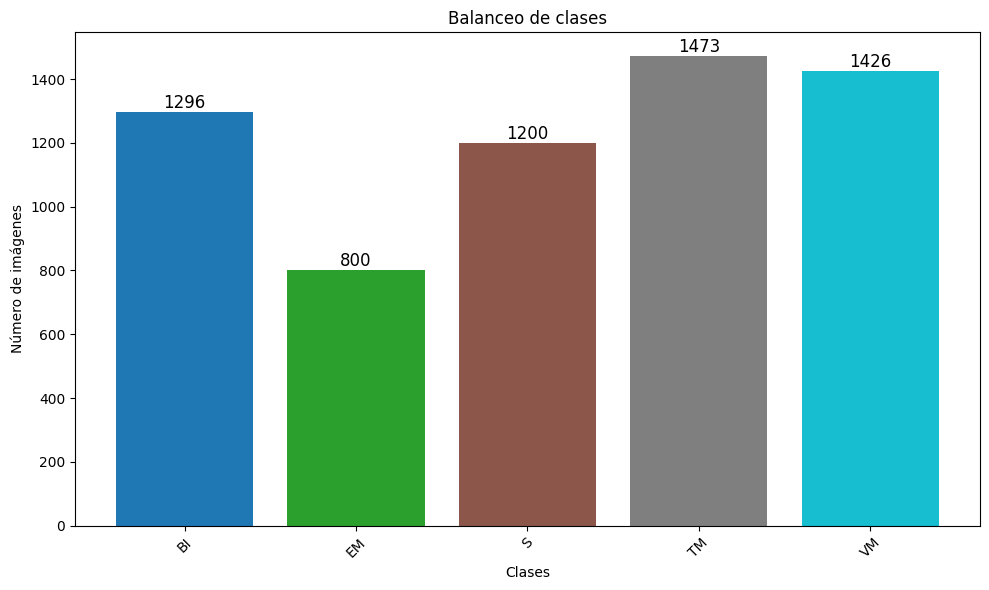

In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Ruta de la carpeta de entrenamiento
ruta_train = r"C:\Users\cadur\Downloads\Urbansonic\Urbanphony\0_Mels_Gen\DATA\Data_Augmentacion"

# Obtener la lista de clases (subcarpetas)
clases = [folder for folder in os.listdir(ruta_train) 
          if os.path.isdir(os.path.join(ruta_train, folder))]

# Contar el número de imágenes en cada clase
conteos = []
for clase in clases:
    ruta_clase = os.path.join(ruta_train, clase)
    num_imagenes = len([f for f in os.listdir(ruta_clase)
                        if os.path.isfile(os.path.join(ruta_clase, f))])
    conteos.append(num_imagenes)

# Configurar el gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))

# Asignar un color distinto a cada barra usando una colormap
# Se usa 'tab10', que proporciona 10 colores distintos; si tienes más clases, puedes cambiar a 'tab20' u otro cmap.
colors = plt.cm.tab10(np.linspace(0, 1, len(clases)))

barras = ax.bar(clases, conteos, color=colors)

# Agregar el número de imágenes sobre cada barra
for barra in barras:
    altura = barra.get_height()
    ax.text(barra.get_x() + barra.get_width()/2, altura, f'{int(altura)}', 
            ha='center', va='bottom', fontsize=12)

ax.set_xlabel('Clases')
ax.set_ylabel('Número de imágenes')
ax.set_title('Balanceo de clases')
plt.xticks(rotation=45)  # Rotar etiquetas si es necesario para mayor claridad
plt.tight_layout()
plt.show()